# Setup

In [1]:
import pandas as pd
import numpy as np

from netcoloc import validation

from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import hypergeom
from statsmodels.stats import contingency_tables

import getpass
import ndex2

# need ddot to parse the ontology
import ddot
from ddot import Ontology

import networkx as nx
import requests

import random

import matplotlib.pyplot as plt
from matplotlib.patches import BoxStyle as bx
from matplotlib.patches import Patch
import seaborn as sns

import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

### Analysis Functions

In [2]:
# from updated netcoloc
def load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, 
             mapping=None, 
             restrict_to=None, use_display=False):
    """
    Function to parse and load mouse phenotype ontology, using DDOT's ontology module

    :param url: URL containing MPO ontology file
    :type url: str
    :return: MPO parsed using DDOT
    :rtype: :py:class:`ddot.Ontology`
    :raises ImportError: If DDOT package is not found
    """

    # download the mammalian phenotype ontology, parse with ddot
    r = requests.get(url, allow_redirects=True)
    open('MPheno_OBO.ontology', 'wb').write(r.content)
    ddot.parse_obo('MPheno_OBO.ontology',
                   'parsed_mp.txt',
                   'id2name_mp.txt',
                   'id2namespace_mp.txt',
                   'altID_mp.txt')

    MP2desc = pd.read_csv('id2name_mp.txt', sep='\t',
                          names=['MP', 'description'], index_col='MP')

    MP2desc = MP2desc.loc[MP2desc.index.dropna()]  # drop NAN from index
    print(len(MP2desc))

    if use_display:
        display(MP2desc.head())

    hierarchy = pd.read_table('parsed_mp.txt',
                              sep='\t',
                              header=None,
                              names=['Parent', 'Child', 'Relation', 'Namespace'])

    if use_genes:
        mouse_mapping = mapping.dropna().loc[:, ("human_ortholog", "MP")].reset_index()
        mouse_mapping = mouse_mapping.loc[:, ("human_ortholog", "MP")]
        mouse_mapping.columns = ["Gene", "Term"]
        if restrict_to is not None:
            mouse_mapping = mouse_mapping.loc[mouse_mapping.Gene.isin(restrict_to)]
        MPO = Ontology.from_table(
            table=hierarchy,
            parent='Parent',
            child='Child',
            add_root_name='MP:00SUPER',
            ignore_orphan_terms=True,
            mapping=mouse_mapping,
            mapping_parent='Term',
            mapping_child='Gene')
    else:
        if use_display:
            display(hierarchy.head())
        MPO = Ontology.from_table(
            table=hierarchy,
            parent='Parent',
            child='Child',
            add_root_name='MP:00SUPER',
            ignore_orphan_terms=True)

    # add description to node attribute
    terms_keep = list(np.unique(hierarchy['Parent'].tolist() + hierarchy['Child'].tolist()))
    MPO.node_attr = MP2desc.loc[terms_keep]

    return MPO


def genes_per_node(MPO):
    node_order = MPO.topological_sorting(top_down=False)
    nodes = [i for i in node_order]
    results = {i: set(MPO.term_2_gene[i]) for i in node_order}
    genes = {i: set(MPO.gene_2_term[i]) for i in MPO.genes}
    while len(nodes) > 0:
        current = nodes.pop()
        children = MPO.parent_2_child[current]
        if len(children) > 0:
            for child in children:
                if child != current:
                    results[current] = results[current].union(results[child])
        for gene in results[current]:
            if gene not in genes.keys():
                genes[gene] = set([current])
            else:
                genes[gene] = genes[gene].union(set([current]))
        else:
            pass
    counts = {k: len(results[k]) for k in results.keys()}
    return counts, genes, results


def community_term_enrichment(community_name, hier_df, MPO, mgi_df, term_counts, gene_to_terms, keep_genes=None, exclude_genes=None):
    """
    :param community_name:
    :param hier_df:
    :param MPO: Mammalian phenotype ontology with gene info
    :param mgi_df: Gene phenotype mapping
    :param term_counts: Number of genes associated with each term
    :param gene_to_terms: Number of terms associated with each gene
    :param keep_genes: List of genes to maintain in the analysis - ONLY these genes will be kept
    :param exclude_genes: List of genes to exclude from the analysis
    """
    # get the genes in the community
    genes = hier_df.loc[community_name, "CD_MemberList"]
    if type(genes) is str:  # split into a list of genes
        genes_all = genes.split(" ")
        N_hier = len(genes_all)
    # only keep genes in the MGI ontology    
    genes = [ g for g in genes_all if g in MPO.genes ]  
    
    # subset genes based on input
    if keep_genes is not None:
        genes = [g for g in genes if g in keep_genes]
        N_hier = len([g for g in genes_all if g in keep_genes])
    if exclude_genes is not None:
        genes = [g for g in genes if g not in exclude_genes]
        N_hier = len([g for g in genes_all if g not in exclude_genes])
    
    # exit if there are no genes remaining
    if len(genes) == 0:
        print("0/"+str(len(genes_all)), "in MPO.genes/seeds")
        return pd.DataFrame()
    
    # Get the terms associated with these genes
    terms = []
    for gene in genes:
        terms += list(gene_to_terms[MPO.genes.index(gene)])

    # Join term totals and observed
    to_test = pd.DataFrame(pd.Series(terms, name="observed").value_counts()).join(pd.Series(term_counts, name="total"))
    M_pool_size = len(G_int.nodes())
    
    # Get odss ratio, p value of odds ratio, and 95% confidence interval
    OR_test = to_test.apply(lambda x: get_contingency_stats(x.observed, x.total, N_hier, M_pool_size), axis=1)
    try: 
        OR_test = pd.concat(list(OR_test), ignore_index=True)
    except TypeError:
        print(OR_test)
        print(N_hier, terms)
    OR_test.index = to_test.index
    to_test = pd.concat([to_test, OR_test], axis=1)
    
    to_test = to_test.assign(hyper_p=lambda z: hypergeom.sf(k=z.observed, M=M_pool_size, n=z.total, N=N_hier))
    desc = MPO.node_attr.loc[to_test.index]
    to_test = to_test.assign(sig_5e6=to_test["hyper_p"] < 5e-6)
    to_test = to_test.join(desc, how="left")
    to_test = to_test.assign(size=N_hier)
    return to_test


def get_contingency_stats(observed, term_size, community_size, network_size):
    q00 = observed
    q01 = term_size - observed
    q10 = community_size - observed
    q11 = network_size - q00 - q01 - q10
    results_table = [[q00, q01], [q10, q11]]
    #print(results_table)
    CT = contingency_tables.Table2x2(results_table)
    OR_p_temp = CT.oddsratio_pvalue()
    OR_CI_temp = CT.oddsratio_confint()
    OR = CT.oddsratio
    #print(CT.chi2_contribs)
    #return CT
    return pd.DataFrame({"OR":OR, "OR_p": OR_p_temp, "OR_CI_lower":OR_CI_temp[0], "OR_CI_upper":OR_CI_temp[1]}, index=[0])

def _get_mp_graph(datafile="parsed_mp.txt"):
    mp_data = pd.read_csv(datafile, sep="\t", header=None)
    mp_data.head()
    mp_graph = nx.from_pandas_edgelist(mp_data, 0,1, create_using=nx.DiGraph)
    return mp_graph


def get_gene_hits(genes, term, MPO, term_mapping):
    if type(genes) is str:
        genes = genes.split(" ")
    term_genes = [MPO.genes[idx] for idx in term_mapping[term]]
    overlap = set(genes).intersection(set(term_genes))
    return overlap

### Plotting Functions

In [3]:
def plot_hbar_comparison(data_all, communities, mps, sig_level=0.05, community_names=None, sort_by=None, 
                         label_number="total", vert=20, color_idx=None, mp_graph=None, horz=10, save=False,
                        ylabel_groups=None):
    # Check inputs --------
    assert len(communities) == len(community_names), "Length of community names and communities must be equal"
    assert sig_level < 1.0 and sig_level > 0
    assert all([c in data_all.name.values for c in communities]), "Not all specified communities in data"
    
    if type(mps) == str and mp_graph is not None:
        mps = [node for node in nx.dfs_preorder_nodes(mp_graph, mps, 1) if node in data_all.index][1:]
    
    # Set up color variables --------
    #colors = [(0/255,158/255,115/255), (0/255,114/255,178/255), (230/255,175/255,0/255), (213/255,94/255, 0/255),
    #         (115/255, 44/255, 87/255)]

    colors = [(14/255,142/255,18/255), (3/255,67/255,223/255), (250/255,160/255,0/255), (181/255,7/255,72/255)]
    colors += [(201/255, 14/255, 169/255)]
    if len(communities) == 1:
        if color_idx is None:
            colors = [colors[1]]
        else:
            colors = [colors[color_idx]]
    elif color_idx is not None:
        colors = [colors[i] for i in color_idx]
    cmap = {comm:colors[c] for c, comm in enumerate(communities)}
    
    # Initialize plotting parameters --------
    height=((1-0.3)/len(communities))
    n_tests = len(communities) * len(mps)
    community_plot_data = []
    data = data_all.loc[mps]
    data = data.loc[data.name.isin(communities)]
    
    ## Perform P-value correction
    if len(data) < n_tests:
        diff = n_tests - len(data)
        data["q"] = fdrcorrection(list(data["OR_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
        data["q_hyper"] = fdrcorrection(list(data["hyper_p"]) + [1 for _ in range(diff)], method="poscorr")[1][:(-1*diff)]
    else:
        data["q"] = fdrcorrection(data["OR_p"], method="poscorr")[1]
        data["q_hyper"] = fdrcorrection(data["hyper_p"], method="poscorr")[1]
    
    # Sort the data
    if sort_by == "q":
        sort_data = data.loc[data.name==communities[0]].sort_values(by=["q", "OR_p"])
        if all([mp in sort_data.index for mp in mps]):
            mps = list(sort_data.index.values)
        else:
            if len(communities) == 1:
                mps = list(sort_data.index.values)
            else:
                extra_mps = [mp for mp in mps if mp not in sort_data.index ]
                mps = list(sort_data.index.values) + extra_mps
    elif sort_by == "observed":
        sort_data = data.loc[data.name==communities[0]].sort_values(by=["q"])
        sort_data = sort_data.sort_values(by=["observed"], ascending=False)
        if all([mp in sort_data.index for mp in mps]):
            mps = list(sort_data.index.values)
        else:
            if len(communities) == 1:
                mps = list(sort_data.index.values)
            else:
                extra_mps = [mp for mp in mps if mp not in sort_data.index ]
                mps = list(sort_data.index.values) + extra_mps
            
            
    for c, comm in enumerate(communities):
        plot_data = pd.DataFrame({"mps":mps, "community":comm, "left":1.0, "width":0.0, "upper":0, "lower":0, 
                                  "fill":[(1,1,1)], "hatch":""}, index=mps)  
        comm_nodes = [node for node in mps if (node in data.loc[data.name==comm].index)]
        results = data.loc[data.name==comm]
        results = results.assign(sig=[cmap[comm] if val<sig_level else (1,1,1) for val in results["q"]])
        sig_bars = results.loc[results["q"] < sig_level].index
        results = results.assign(hypsig=["/" if val < sig_level else "" for val in results.q_hyper])
        try:
            plot_data = plot_data.assign(left=[min(1, results.loc[mp, "OR"]) if mp in results.index else 1.0 for mp in plot_data.index], 
                                         width=[max(1-results.loc[mp, "OR"], results.loc[mp, "OR"]-1) if mp in results.index else 0.0 for mp in plot_data.index], 
                                         upper=[results.loc[mp, "OR_CI_upper"] - results.loc[mp, "OR"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        lower =[results.loc[mp, "OR"] - results.loc[mp, "OR_CI_lower"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        fill =[results.loc[mp, "sig"] if mp in results.index else (1,1,1) for mp in plot_data.index], 
                                        hatch = [results.loc[mp, "hypsig"] if mp in results.index else ""for mp in plot_data.index])
        except:
            return plot_data, results, comm
        neg_bars = plot_data.loc[plot_data["left"] < 1].index
        plot_data = plot_data.assign(upper=[results.loc[x, "OR_CI_upper"] - 1 if x in neg_bars else plot_data.loc[x, "upper"] for x in plot_data.index])
        plot_data = plot_data.assign(lower=[1- results.loc[x, "OR_CI_lower"] if x in neg_bars else plot_data.loc[x, "lower"] for x in plot_data.index])
        # TODO finish up to get the right color scheme as before without iteration
        #return plot_data, cmap, comm, sig_bars
        plot_data = plot_data.assign(edgecolor=[cmap[comm] if mp in results.index else (1,1,1) for mp in plot_data.index ])
        plot_data = plot_data.assign(ecolor=[(darken(cmap[comm])) if mp in sig_bars else (alpha_blending(cmap[comm], 0.3)) for mp in plot_data.index])
        plot_data = plot_data.assign(y=[-1*(i+c*height) for i in range(len(plot_data))])
    
        
        community_plot_data.append(plot_data)

    all_plot_data = pd.concat(community_plot_data, axis=0)
    
    #return all_plot_data
    plt.figure(figsize=(horz, vert), frameon=False)
    ax = plt.subplot(111)
    ax.barh(data=all_plot_data, y="y", height=height, left="left", color="fill", width="width", 
             xerr=(all_plot_data.lower, all_plot_data.upper), 
             edgecolor="edgecolor", ecolor="ecolor", alpha=0.7)

    handles = [Patch(facecolor=cmap[comm]) for comm in communities]
    handle_map = {community_names[c] +  " (N=" + str(int(data.loc[data["name"]==comm, "size"].values[0])) + ")": colors[c] for c, comm in enumerate(communities)}
    
    if label_number in ["total"]:
        ylabels = []
        for node in mps:
            try:
                ylabels.append(data.loc[node, "description"].values[0] + " (" + str(int(data.loc[node, label_number][0]))+")")
            except AttributeError:
                #print(data.loc[node, "description"])
                #print(data.loc[node, label_number])
                ylabels.append(data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")")

    elif label_number == "observed" and len(communities) == 1:
        ylabels = [data.loc[node, "description"] + " (" + str(int(data.loc[node, label_number]))+")" for node in mps]

    elif label_number == "percent_community" and len(communities) == 1:
        comm_size = data["size"].values[0]/100
        ylabels = [data.loc[node, "description"] + 
                   " (" + str(round(int(data.loc[node, "observed"])/comm_size))+'%)'  if node in data.index else
                   data.loc[node, "description"] + " (0%)" for node in mps]
    else:
        ylabels = [data_all.loc[node, "description"].values[0] for node in mps]
        
    ylabels = [desc.split("abnormal ")[1] if "abnormal" in desc else desc for desc in ylabels] 
    ylabels = [desc.replace("physiology", "phys.") for desc in ylabels]
    ylabels = [desc.replace("morphology", "morph.") for desc in ylabels]
    ylabels = [desc.replace(" phenotype", "") for desc in ylabels]
    a=ax.set_yticks(ticks=[-1*(i + height*len(communities)/4) for i in range(len(mps))] )
    ax.set_yticklabels(labels=ylabels)
    ax.set_xlabel("Odds ratio with 95% confidence interval")
    #plt.xlim((0, max(all_plot_data.width + all_plot_data.upper)*1.1))
    if max(all_plot_data.width) > 9:
        plt.xscale("log")
    ax.set_ylim((-1* len(mps), 3))
    
    if ylabel_groups is not None:
        if len(ylabel_groups) == len(ylabels):
            y_colors = {0:"#0C3952", 1:"#696264"}
            for ytick, color in zip(ax.get_yticklabels(), ylabel_groups):
                ytick.set_color(y_colors[color])
        else:
            print('Number of ylabel groups does not match number of labels')
            print("Labels:", len(ylabels))
            print("Label groups:", len(ylabel_groups))
    
    
    if sort_by is None:
        plt.legend(handles, handle_map, loc="upper right")
    else:
        plt.legend(handles, handle_map, loc="upper left")
    if save:
        plt.savefig('/cellar/users/snwright/Data/Transfer/'+"_".join(communities)+'.png', format='png', dpi=1200, bbox_inches="tight")
    return data, ax


def alpha_blending(foreground_tuple, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return final


def darken(color_tuple, factor=0.25):
    color = np.array(color_tuple)
    color = color * (1-factor)
    return tuple(color)
    

In [4]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/(xmax+1), pos[node][1])
    return pos


def draw_significance_hierarchy(data, community, root, mpG, MPO, hier_df_genes, term_mapping, select_on="q", size_by="OR", 
                                color_by="q", alpha_by=None, 
                                vert=10, label="all", descriptive_labels=False,
                               adjust_root=0):
    
    comm_genes = hier_df_genes.loc[community, "CD_MemberList"].split(" ")
    data = data.loc[data.name==community]
    stop = False
    sigH = []
    queue = []
    if select_on=="hypergeom":
        all_hypers = {root:1.0}
    current=root
    previous=root
    data = data.assign(ppv=data.observed/data.total)
    while not stop:
        children = [node for node in nx.dfs_preorder_nodes(mpG, current, 1)]
        if len(children) == 0:
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True
        else:
            node_order = [node for node in children if node in data.index]
            subset = data.loc[node_order]
            subset.loc[:, "q"] = fdrcorrection(subset.OR_p, method="poscorr")[1]
            if select_on=="q":
                new_sigs = list(subset.loc[subset.q < subset.loc[current, "q"], "MP"].values)
            elif select_on=="OR":
                new_sigs = list(subset.loc[subset.OR > subset.loc[current, "OR"], "MP"].values)
            elif select_on=="ppv":
                new_sigs = list(subset.loc[subset.ppv > subset.loc[current, "ppv"], "MP"].values)
            elif select_on=="hypergeom":
                parent_size = term_counts[current]
                parent_observed = data.loc[current, "observed"]
                parent_hyper = all_hypers[current]
                new_sigs = []
                for child in node_order:
                    child_hyper = hypergeom.sf(M=parent_size, n=parent_observed, N=term_counts[child], 
                                            k=subset.loc[child, "observed"]-1)
                    if child_hyper < parent_hyper:
                        new_sigs.append(child)
                        all_hypers[child] = child_hyper
            elif select_on=="qxOR":
                subset = subset.assign(qxOR=-1 * np.log10(subset.q) * subset.OR)
                new_sigs = list(subset.loc[subset.qxOR > subset.loc[current, "qxOR"], "MP"].values)
        
            queue += [(current, sig) for sig in new_sigs if sig != current]
            sigH.append((current, previous, subset.loc[current, "q"], subset.loc[current, "OR"], subset.loc[current, "observed"]))
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True  
    sigG = nx.DiGraph()
    sigG.add_node(sigH[0][0], OR=sigH[0][3], q=-1*np.log10(sigH[0][2]), obs=sigH[0][4])
    for edge in sigH[1:]:
        sigG.add_node(edge[0], OR=edge[3], q=-1*np.log10(edge[2]), obs=edge[4])
        if sigG.in_degree[edge[0]] < 1:
            sigG.add_edge(edge[1], edge[0])
    node_data = pd.DataFrame.from_dict(sigG.nodes, orient='index')
    # add the gene hits for each node
    hit_sets = [list(get_gene_hits_no_annotation(comm_genes, term, MPO, term_mapping)) for term in node_data.index.values]
    node_data = node_data.assign(hits=hit_sets)
    H = nx.convert_node_labels_to_integers(sigG, label_attribute="node_label")
    plt.figure(figsize=(20,vert))
    pos = hierarchy_pos(sigG,root=root, leaf_vs_root_factor=1)
    # get term descriptions
    descriptions = MPO.node_attr
    descriptions.index.name=None
    # create sizes
    max_size=1000
    min_size=100
    node_sizes= normalize_to_range(node_data[size_by], upper=max_size, lower=min_size)
    # get transparency values
    max_alpha=1
    min_alpha=0.2
    if alpha_by in ["q", "OR", "obs"]:
        node_alphas = list(normalize_to_range(1 - 1 / node_data[alpha_by].values, upper=max_alpha, lower=min_alpha))
    else:
        node_alphas = 1
    # get labels
    hrz="left"
    vrt="center"
    if label == "all":
        node_labels = {node:node for node in node_data.index.values}
        hrz = "center"
        vrt='bottom'
    elif label == "leaf":
        if descriptive_labels:
            labels = [" "*(2+int(node_sizes[i]/200)) + descriptions.loc[node, "description"] if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        else:
            labels = [" "*(2+int(node_sizes[i]/200)) + node if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        node_labels = {node_data.index.values[i]:labels[i] for i in range(len(labels))}
    # plot results
    pos2 = {key:(-1*pos[key][1], pos[key][0]) for key in pos.keys()}
    
    pos2[root] = (-1 * adjust_root, pos2[root][1])
    nx.draw_networkx(sigG,with_labels=True, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color="white", label="test", edgelist=None,
                    labels=node_labels, horizontalalignment=hrz, verticalalignment=vrt, font_size=12)
    
    if color_by == "q":
        c_min = 0
        c_max = 10
    elif color_by == "OR":
        c_min = -0.5
        c_max = 10
    else:
        c_min = min(node_data[color_by])
        c_max = max(node_data[color_by])
    
    n = nx.draw_networkx_nodes(sigG, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color=node_data[color_by], cmap="viridis", label="test", alpha = node_alphas,
                              vmin=c_min, vmax=c_max)
    # edge labels for edges out of root
    if descriptive_labels:
        edge_labels = [descriptions.loc[node, "description"] if sigG.has_edge(root, node) else "" for node in sigG.nodes]
    else:
        edge_labels = [node if sigG.has_edge(root, node) else "" for node in sigG.nodes]

    edge_labels = {(root, node_data.index.values[i]):edge_labels[i] for i in range(len(edge_labels))}
    if label != "all":
        nx.draw_networkx_edge_labels(sigG, pos=pos2, edge_labels=edge_labels, label_pos=0.48, 
                                     bbox={"boxstyle":bx.Round(pad=0, rounding_size=0.99),
                                          "facecolor":"white"})
    #sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_data[color_by]), vmax=max(node_data[color_by])))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=c_min, vmax=c_max))
    sm._A = []
    plt.colorbar(sm, orientation="horizontal", label=color_by, shrink=0.3, pad =0.02 )
    #nx.draw_networkx_labels(sigG, pos=pos2, font_size=12, verticalalignment="bottom", horizontalalignment="left")
    #plt.legend(n)
    legend_G, legend_sizes, legend_pos = create_legend_size_graph(node_sizes, node_data, size_by=size_by, adjust_root=adjust_root)
    #return legend_G, legend_sizes, legend_pos
    try:
        nx.draw_networkx(legend_G, pos =legend_pos, node_size=legend_sizes, node_color="black", nodelist=list(legend_G.nodes()),
                        verticalalignment="center", font_color="white")
    except ValueError as e:
        print(legend_sizes, legend_G.nodes())
        print("Could not plot size legend.", e)    
    
    print("PARENT:", root, descriptions.loc[root, "description"])
    plt.xlim(-1 * adjust_root-0.05, max([pos2[k][0] for k in pos2]) * 1.5)
    plt.show()
    return node_data

def create_legend_size_graph(node_sizes, node_data, min_size=100, max_size=1000, size_by='obs', adjust_root=0):
    G = nx.Graph()
    lower = min([sz for sz in node_sizes])
    true_lower = min(node_data[size_by])
    upper = max([sz for sz in node_sizes])
    true_upper = max(node_data[size_by])
    true_q1, true_q3 = [round(x) for x in np.quantile([true_lower, true_upper], [0.3333, 0.66667])]
    q1, q3 = np.quantile([lower, upper], [0.3333, 0.66667])
    positions = {}
    nodes_to_plot = list(set([round(true_lower), round(true_q1), round(true_q3),  round(true_upper)]))
    nodes_to_plot.sort()
    for i, node in enumerate(nodes_to_plot):
        G.add_node(node)
        positions[node] = (0.01 + 0.05*(i-1) - adjust_root, 0.4)
    if len(positions) == 1:
        leg_sizes = (min_size+max_size)/2
    elif len(positions) == 2:
        leg_sizes = [lower, upper]
    elif len(positions) == 3:
        leg_sizes = [lower, np.mean([q1, q3]), upper]
    else:
        leg_sizes = [lower, q1, q3, upper]
        
    return G, leg_sizes, positions
      

def normalize_to_range(data, upper, lower):
    if max(data) - min(data) == 0:
        norm_data = (data / data) * (upper+lower)/2
    else:
        # normalize to unit
        norm_data = (data - min(data))/(max(data)-min(data))
        # normalize to range
        norm_data = norm_data * (upper - lower) + lower
    return norm_data


## Load Data

In [5]:
## LOAD PCNET
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# pcnet appears to have some self edges... should remove them. 
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_int.nodes))
print('\nnumber of edges:')
print(len(G_int.edges))

nodes = list(G_int.nodes)
pd.DataFrame(G_int.nodes).to_csv("pcnet_node_list.tsv", sep="\t", index=False, header=False)

number of nodes:
18820

number of edges:
2693109


In [6]:
## LOAD Hierarchy
hier_df_genes = pd.read_csv("BMI_hierarchy/hier_df_genes.tsv", sep="\t", index_col=0)

In [7]:
## LOAD Seed Genes
human_seeds = []
rat_seeds = []
all_seeds = human_seeds + rat_seeds

### Load Mouse Data

In [8]:
mgi_df = validation.load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24212...done.
Finished.
38 input query terms found dup hits:
	[('Abo', 3), ('Adam1a', 2), ('Adam1b', 2), ('Adam5', 2), ('Casp12', 2), ('Ccdc39', 2), ('Chaserr', 2
12299 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

In [9]:
MPO2 = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', use_genes=True, mapping=mgi_df)

14626


In [10]:
mp_graph = _get_mp_graph()
top_level = [node for node in nx.dfs_preorder_nodes(mp_graph, "MP:0000001", 1) if node not in ["MP:0003012", "MP:0002873"]][1:]

# Perform Enrichment

In [11]:
phenotypes = []
term_counts, gene_mapping, term_mapping = genes_per_node(MPO2)
for community in hier_df_genes.index:
    x = community_term_enrichment(community, hier_df_genes, MPO2, mgi_df, term_counts, gene_mapping, exclude_genes=all_seeds)
    x = x.assign(name=community)
    phenotypes.append(x)

In [12]:
results = pd.concat(phenotypes)
results = results.assign(MP=results.index)

## Get Gene Hits

In [13]:
hits = get_gene_hits(genes=hier_df_genes.loc["C877", "CD_MemberList"], term="MP:0005451", MPO=MPO2, term_mapping=term_mapping)
for hit in hits:
    print(hit)

LIN7C
TNIK
FUS
DUSP6
BACE2
SCN4A
RB1
SDC3
PTPRD
SOX8
SPG7
CAMK4
MSI2
ILK
SLIT3
POMC
MAP2K1
MYF5
PIK3R1
SLC38A10
PNPLA6
GBA
ABL1
KDM3B
CRKL
SLC25A12
MAN2B1
DMD
PHF2
GPR61
SOX3
SLITRK6
SYT2
BCL2
CDX2
ZFAND2B
LZTFL1
FAM20C
PPP3CA
NRCAM
ZBTB20
CHST14
VIPR1
MRTFB
RASGRF1
AGPAT1
LMTK3
KDM3A
NR2F1
GNAO1
IGF1R
SGCB
TRIO
GNAI2
UTRN
INSR
BDNF
HCFC1
PLEC
CSPG4
C2CD5
SKIL
CORIN
SCUBE2
MC4R
SYTL4
KAT14
AKAP6
CLN3
LSAMP
MYH4
HNF4G
IGF2R
NCOA3
PKP3
NEIL1
BBS2
RCAN2
ZSWIM6
CACNA1D
PRLHR
TUB


## Visualize Results
### Bar chart

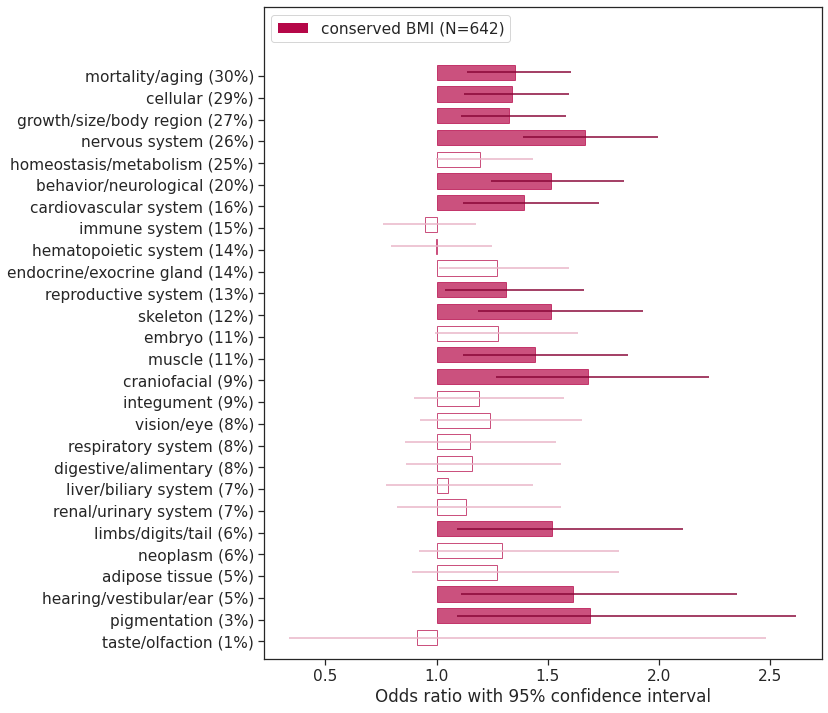

In [14]:
a = plot_hbar_comparison(results, communities=["C877"], mps=top_level, color_idx=3, vert = 12, mp_graph=mp_graph,
                         sig_level=0.05, community_names=["conserved BMI"], sort_by="observed", label_number="percent_community")

### Network Plot

In [15]:
n = draw_significance_hierarchy(results.loc[results.observed>=2], "C877", "MP:0009642", mp_graph, MPO2, hier_df_genes, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="x",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.1)

NameError: name 'get_gene_hits_no_annotation' is not defined